In [1]:
import numpy as np
import struct
from array import array
from os.path import join
import json

%matplotlib inline
import random
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, precision_score
from scipy.spatial.distance import cdist
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_img_path = "train-images.idx3-ubyte"
train_lab_path = "train-labels.idx1-ubyte"
test_img_path = "t10k-images.idx3-ubyte"
test_lab_path = "t10k-labels.idx1-ubyte"

In [3]:
def get_data(ipath, lpath):
    labels, images = [], []

    with open(ipath, "rb") as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError
        image_data = array("B", f.read())

    for i in range(size):
        images.append([0]*rows*cols)
    for i in range(size):
        images[i][:] = np.array(image_data[i*rows*cols:(i+1)*rows*cols]).reshape(28, 28)

    with open(lpath, "rb") as f:
        magic, size = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError
        labels = array("B", f.read())

    return images, labels

In [4]:
x_train, y_train = get_data(train_img_path, train_lab_path)
x_test, y_test = get_data(test_img_path, test_lab_path)

In [5]:
x_train[0][0], len(x_train), y_train[0]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=uint8),
 60000,
 5)

In [6]:
def show_images(images, titles):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1

    for i in zip(images, titles):
        img = i[0]
        title = i[1]
        plt.subplot(rows, cols, index)
        plt.imshow(img, cmap = plt.cm.gray)
        if title != "":
            plt.title(title, fontsize = 15)
        index += 1

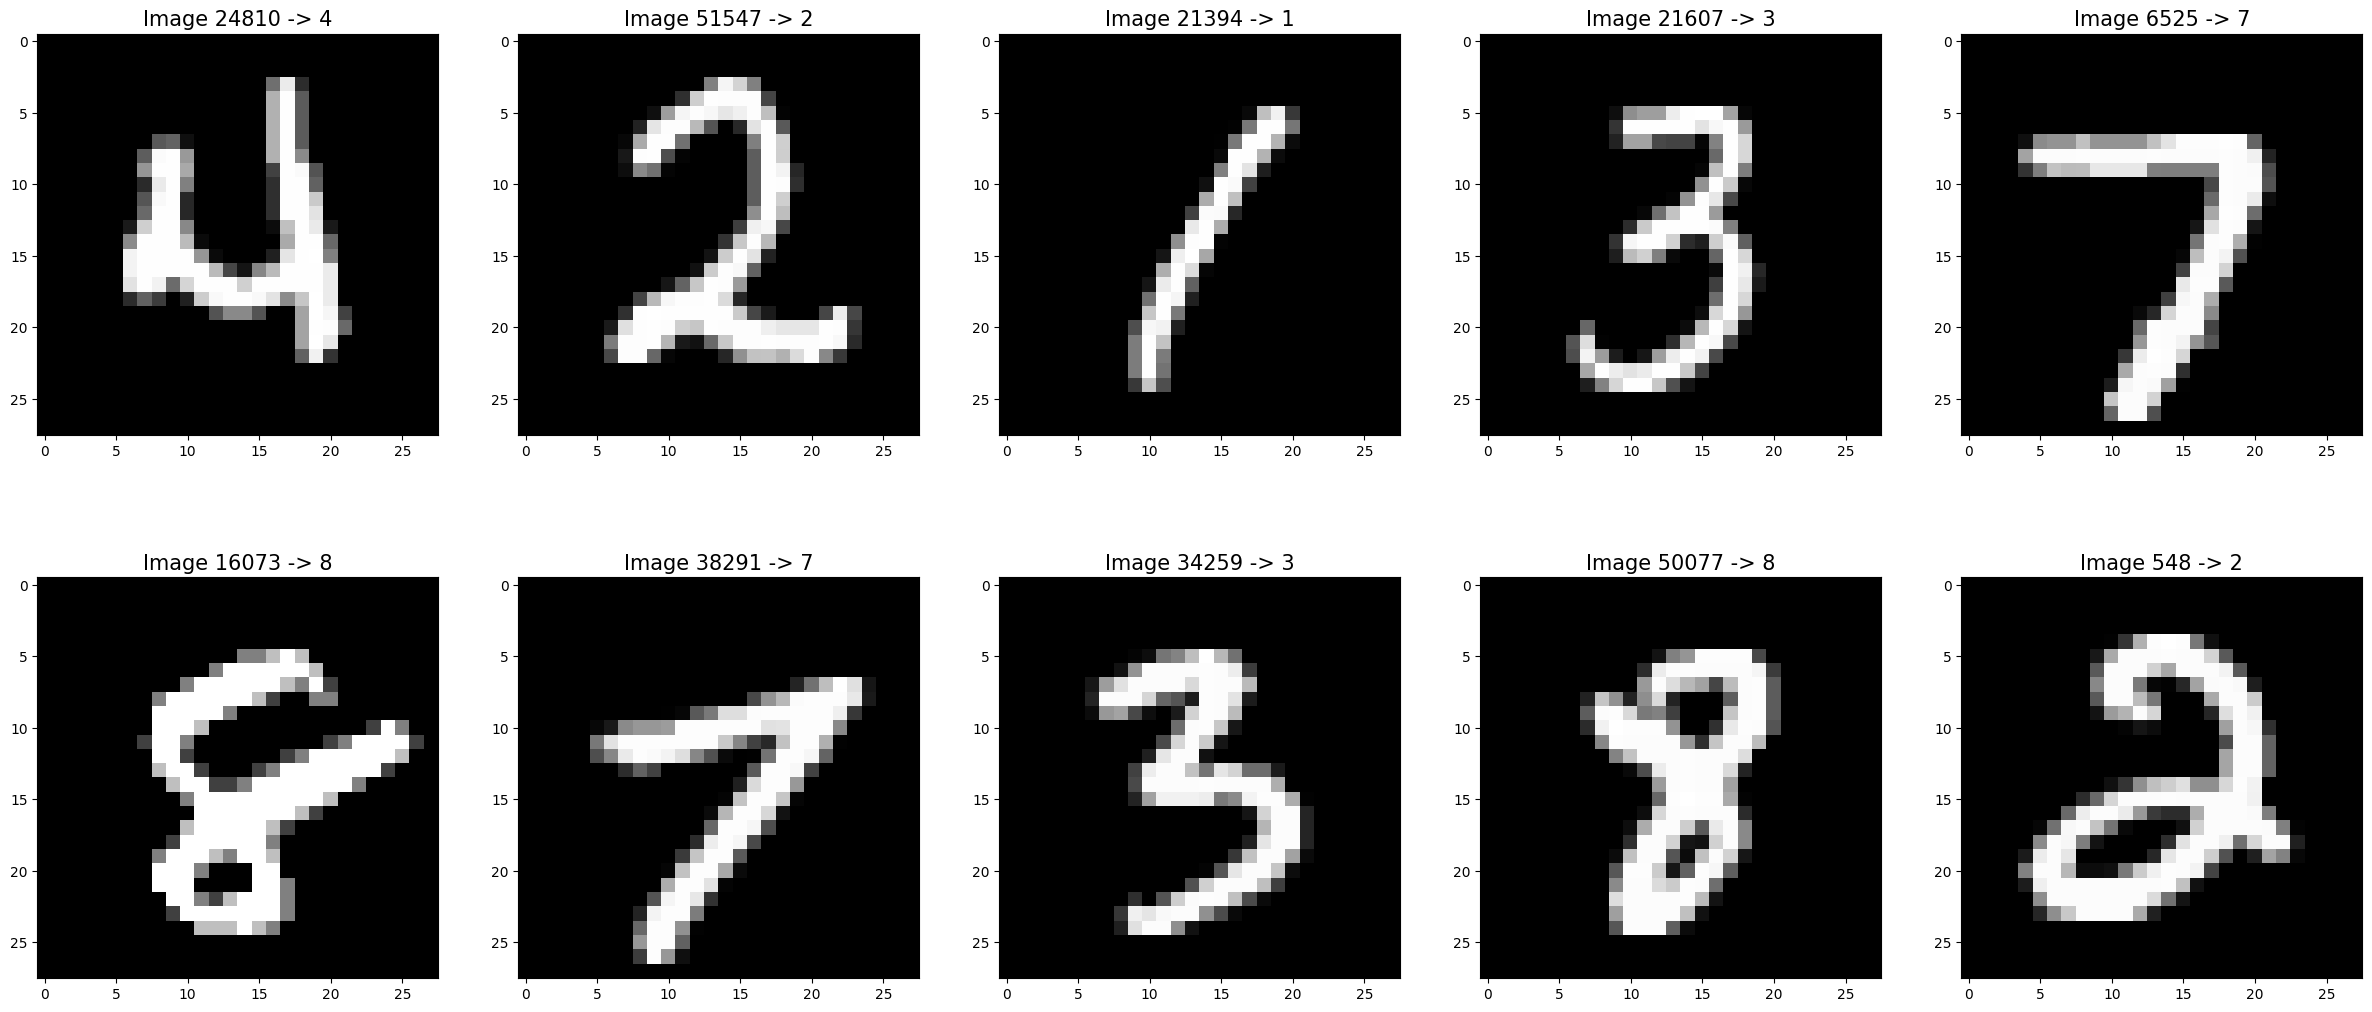

In [7]:
img_show = []
lab_show = []

for i in range(10):
    r = random.randint(1, 60000)
    img_show.append(x_train[r])
    lab_show.append(f"Image {r} -> {y_train[r]}")

show_images(img_show, lab_show)

## Baseline

In [8]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [9]:
x_train = x_train/255
x_test = x_test/255

In [10]:
x_train[0][0]

0.0

In [11]:
def KNN(x_train, y_train):
    knn = KNeighborsClassifier(1)
    knn.fit(x_train, y_train)
    return knn

In [12]:
def get_random_sample(x_train, y_train, n):
    index = np.random.choice(x_train.shape[0], n, replace=False)
    return x_train[index], y_train[index]

In [13]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [14]:
baseline_accuracy = []
baseline_precision = []

for M in [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]:
  xt, yt = get_random_sample(x_train, y_train, M)
  knn = KNN(xt, yt)
  y_pred = knn.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  baseline_accuracy.append(accuracy)
  precision = precision_score(y_test, y_pred, average=None)
  baseline_precision.append(precision)
  print(f"Baseline accuracy for M={M} => {accuracy}")
  print(f"Baseline precision score for M={M} => {precision}")

Baseline accuracy for M=500 => 0.8574
Baseline precision score for M=500 => [0.89828897 0.83308715 0.9550173  0.84662577 0.88325991 0.78131635
 0.93171806 0.82513661 0.88794153 0.77052239]
Baseline accuracy for M=1000 => 0.8882
Baseline precision score for M=1000 => [0.90355805 0.87840998 0.96025779 0.87785501 0.89508197 0.86258661
 0.92236977 0.8432971  0.92065344 0.83131313]
Baseline accuracy for M=5000 => 0.9344
Baseline precision score for M=5000 => [0.94876847 0.9274526  0.97473684 0.92596249 0.94184839 0.90690033
 0.95228426 0.93059629 0.9603624  0.88195777]
Baseline accuracy for M=10000 => 0.9504
Baseline precision score for M=10000 => [0.968      0.94856661 0.97568389 0.93267327 0.95859213 0.92105263
 0.96189495 0.93927894 0.97433036 0.92632613]
Baseline accuracy for M=15000 => 0.955
Baseline precision score for M=15000 => [0.9593254  0.9559322  0.97392177 0.94263106 0.97151899 0.9376392
 0.96502058 0.94701349 0.9726776  0.92642788]
Baseline accuracy for M=20000 => 0.9587
Basel

## Method 1 : K-Means

In [15]:
def run_kmeans(n, x_train, y_train, x_test, y_test):
  try:
    kmeans = pickle.load(open("kmeans"+str(n)+".pkl", "rb"))
  except:
    kmeans = KMeans(n_clusters = n)
    kmeans.fit(x_train)
    pickle.dump(kmeans, open("kmeans"+str(n)+".pkl", "wb"))

  final_dist = []
  for c in kmeans.cluster_centers_:
    dist = []
    for x in x_train:
      dist.append(abs(c-x).sum())
    final_dist.append(dist)

  kmeans_accuracy = []
  kmeans_precision = []

  for M in [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]:
    x_subset, y_subset = [], []

    thr = M//n

    for i in range(n):
      idx = np.argsort(final_dist[i])
      for j in x_train[idx[:thr]]:
        x_subset.append(j)
      for j in y_train[idx[:thr]]:
        y_subset.append(j)

    x_subset = np.asarray(x_subset)
    y_subset = np.asarray(y_subset)
    # print(x_subset.shape, y_subset.shape)
    knn = KNN(x_subset, y_subset)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    kmeans_accuracy.append(accuracy)
    precision = precision_score(y_test, y_pred, average=None)
    kmeans_precision.append(precision)
    print(f"Kmeans accuracy for K={n} M={M} => {accuracy}")
    print(f"Kmeans precision score for M={M} => {precision}")
  print("--"*75)

  return kmeans_accuracy, kmeans_precision


In [16]:
kmeans_accuracy = []
kmeans_precision = []
for n in [10, 50, 100, 150, 200, 250]:
  accuracy, precision = run_kmeans(n, x_train, y_train, x_test, y_test)
  kmeans_accuracy.append(accuracy)
  kmeans_precision.append(precision)

Kmeans accuracy for K=10 M=500 => 0.7167
Kmeans precision score for M=500 => [0.86034659 0.70632436 0.88888889 0.67540984 0.88012618 0.72621359
 0.80384968 0.72881356 0.74186308 0.49003517]
Kmeans accuracy for K=10 M=1000 => 0.7552
Kmeans precision score for M=1000 => [0.83556405 0.75755541 0.89824121 0.71660959 0.80961183 0.7496063
 0.85686081 0.78146453 0.77351916 0.54977806]
Kmeans accuracy for K=10 M=5000 => 0.8326
Kmeans precision score for M=5000 => [0.87189293 0.83844428 0.9031556  0.80938967 0.90117253 0.82548794
 0.86489152 0.87784679 0.89056604 0.65539568]
Kmeans accuracy for K=10 M=10000 => 0.8867
Kmeans precision score for M=10000 => [0.88720379 0.88179669 0.943194   0.8657845  0.93043478 0.88435374
 0.88855721 0.90640895 0.93037215 0.7884452 ]
Kmeans accuracy for K=10 M=15000 => 0.9051
Kmeans precision score for M=15000 => [0.88878505 0.89638554 0.94105481 0.9038835  0.9474313  0.90568182
 0.90835851 0.92068273 0.95023697 0.81898067]
Kmeans accuracy for K=10 M=20000 => 0.9

## Method 2 : CNN (Condensed Nearest Neighbors)

In [17]:
def CNN(x_train, y_train, x_test, y_test):
  idx = []
  for i in range(10):
    idx.append(np.random.choice(np.where(y_train == i)[0], size=1)[0])

  x_subset = list(x_train[idx])
  y_subset = list(y_train[idx])

  cnn_accuracy = []
  cnn_precision = []

  for M in [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]:
    flag = False
    prev = 0

    try:
      x_subset = pickle.load(open(f"cnn_x_{M}.pkl", "rb"))
      y_subset = pickle.load(open(f"cnn_y_{M}.pkl", "rb"))
    except:
      while len(x_subset) < M:
        if len(x_subset) > 9000:
          break
        prev = len(x_subset)
        # print(f"Subset length : {len(x_subset)}")
        knn = KNN(x_subset, y_subset)

        for i in range(len(x_train)):
          if i in idx:
            continue
          pred = knn.predict(np.asarray([x_train[i]]))

          if pred[0] != y_train[i]:
            x_subset.append(x_train[i])
            y_subset.append(y_train[i])
            idx.append(i)

            if len(x_subset) == M:
              flag = True
              break

        if flag:
          break

      pickle.dump(x_subset, open(f"cnn_x_{M}.pkl", "wb"))
      pickle.dump(y_subset, open(f"cnn_y_{M}.pkl", "wb"))

    # x_subset = np.asarray(x_subset)
    # y_subset = np.asarray(y_subset)
    knn = KNN(np.asarray(x_subset), np.asarray(y_subset))
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    cnn_accuracy.append(accuracy)
    precision = precision_score(y_test, y_pred, average=None)
    cnn_precision.append(precision)
    print(f"CNN accuracy for M={M} => {accuracy}")
    print(f"CNN precision score for M={M} => {precision}")

  return cnn_accuracy, cnn_precision

In [18]:
cnn_accuracy, cnn_precision = CNN(x_train, y_train, x_test, y_test)

CNN accuracy for M=500 => 0.8032
CNN precision score for M=500 => [0.87655502 0.96309112 0.81897386 0.83136095 0.80474649 0.72937294
 0.89254386 0.74670185 0.79378882 0.65210955]
CNN accuracy for M=1000 => 0.8782
CNN precision score for M=1000 => [0.93374108 0.89848122 0.94031414 0.86102719 0.84812623 0.83071749
 0.93949045 0.87719298 0.8664422  0.78767773]
CNN accuracy for M=5000 => 0.9166
CNN precision score for M=5000 => [0.94589178 0.96830986 0.94510978 0.8804243  0.90796277 0.87995595
 0.95207668 0.90874159 0.92653509 0.8490566 ]
CNN accuracy for M=10000 => 0.9485
CNN precision score for M=10000 => [0.96871847 0.96413322 0.97111554 0.93267327 0.9476386  0.92299107
 0.9697286  0.94736842 0.95918367 0.89990375]
CNN accuracy for M=15000 => 0.9485
CNN precision score for M=15000 => [0.96871847 0.96413322 0.97111554 0.93267327 0.9476386  0.92299107
 0.9697286  0.94736842 0.95918367 0.89990375]
CNN accuracy for M=20000 => 0.9485
CNN precision score for M=20000 => [0.96871847 0.96413322 

## Method 3 : Interval-Diverse Distance Sampling (IDDS)

In [ ]:
def IDDS(x_train, y_train, x_test, y_test):
  idx = []
  labels = {}

  for i in range(10):
    labels[i] = np.where(y_train == i)[0]
    idx.append(np.random.choice(labels[i], size=1)[0])

  x_start = list(x_train[idx])

  dist = {}

  for i in range(10):
    d = []
    for x in x_train:
      d.append(abs(x_start[i]-x).sum())

    dist[i] = list(zip(x_train[labels[i]], d))
    dist[i].sort(key = lambda a:a[1])

  idds_accuracy = []
  idds_precision = []

  for M in [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]:
    n = M//10

    x_subset = []
    y_subset = []

    for i in range(10):
      thr = len(dist[i])//n

      for x in np.asarray(dist[i])[range(0, len(dist[i]), thr)]:
        x_subset.append(x[0])
        y_subset.append(i)

    knn = KNN(np.asarray(x_subset), np.asarray(y_subset))
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    idds_accuracy.append(accuracy)
    precision = precision_score(y_test, y_pred, average=None)
    idds_precision.append(precision)
    print(f"IDDS accuracy for M={M} => {accuracy}")
    print(f"IDDS precision score for M={M} => {precision}")

  return idds_accuracy, idds_precision

In [20]:
idds_accuracy, idds_precision = IDDS(x_train, y_train, x_test, y_test)

IDDS accuracy for M=500 => 0.8451
IDDS precision score for M=500 => [0.9104187  0.83543365 0.93896714 0.84210526 0.88063063 0.79612756
 0.89336016 0.82409178 0.87068966 0.70240137]
IDDS accuracy for M=1000 => 0.8859
IDDS precision score for M=1000 => [0.91475096 0.88540031 0.93962678 0.87132725 0.89289502 0.83910615
 0.92315574 0.89447236 0.9044289  0.80572963]
IDDS accuracy for M=5000 => 0.9364
IDDS precision score for M=5000 => [0.9481409  0.936311   0.97077244 0.92821031 0.95078534 0.90979098
 0.95674562 0.92240543 0.96       0.88636364]
IDDS accuracy for M=10000 => 0.9513
IDDS precision score for M=10000 => [0.95759369 0.94789916 0.97583082 0.94583751 0.96439791 0.92872807
 0.96516393 0.94180407 0.97098214 0.91795367]
IDDS accuracy for M=15000 => 0.958
IDDS precision score for M=15000 => [0.97094188 0.9536647  0.97415507 0.95841785 0.96296296 0.93099671
 0.97104447 0.95575221 0.97192225 0.93093385]
IDDS accuracy for M=20000 => 0.9612
IDDS precision score for M=20000 => [0.96716418 

## Plots of Accuracy

In [21]:
def plot(x1, y1, x2, y2, label):
  plt.figure(figsize=(7,4))
  plt.plot(x1, y1, label = "Baseline", linestyle="-", marker="o")
  plt.plot(x2, y2, label = label, linestyle="-.", marker="x")
  plt.xlabel("Sample Size")
  plt.ylabel("Accuracy")
  plt.title(f"Comparison of baseline and {label}")
  plt.legend()
  plt.show()

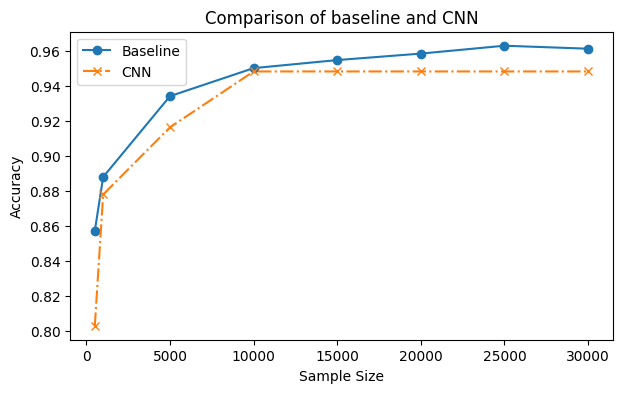

In [22]:
M = [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]

plot(M, baseline_accuracy, M, cnn_accuracy, "CNN")

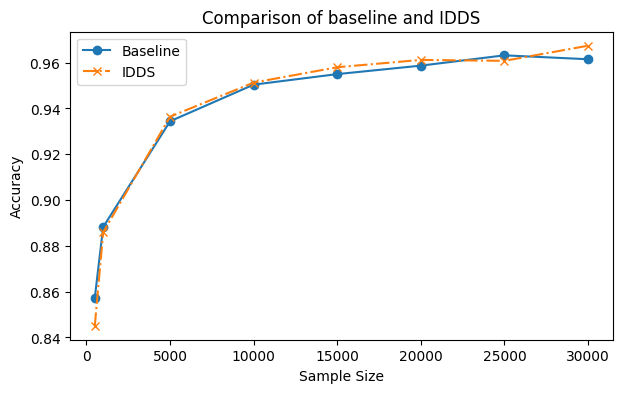

In [23]:
plot(M, baseline_accuracy, M, idds_accuracy, "IDDS")

In [24]:
def plot_kmeans(x1, y1, x2, y2, K, M):
  plt.figure(figsize=(8,5))
  plt.plot(x1, y1, label = "Baseline", linestyle="-.", marker="o")
  i = 0
  for y in y2:
    plt.plot(x2, y, label=f"Kmeans (k={K[i]})", linestyle="-", marker=M[i])
    i += 1
  plt.xlabel("Sample Size")
  plt.ylabel("Accuracy")
  plt.title(f"Comparison of baseline and K-Means")
  plt.legend()
  plt.show()

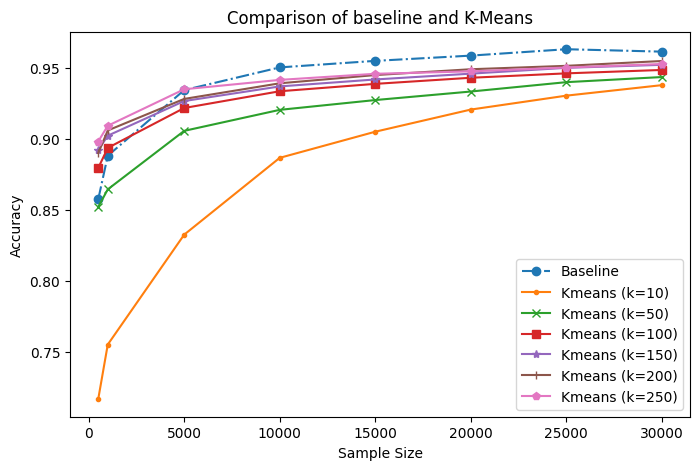

In [25]:
plot_kmeans(M, baseline_accuracy, M, kmeans_accuracy, [10, 50, 100, 150, 200, 250], [".","x","s","*","|","p"])

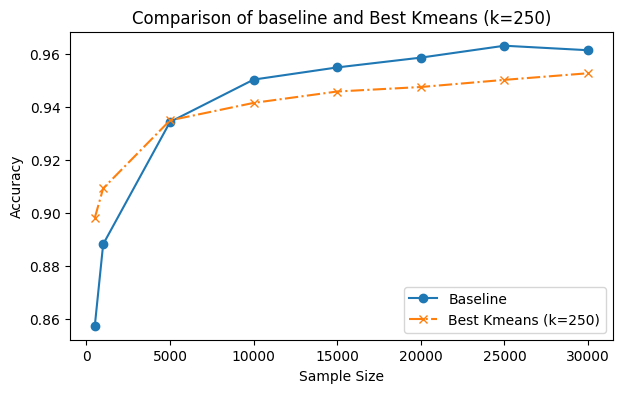

In [26]:
plot(M, baseline_accuracy, M, kmeans_accuracy[-1], "Best Kmeans (k=250)")

## Method 4 : Ensemble Model

In [27]:
def kmeans_subset(x_train, y_train, n, m):
  try:
    kmeans = pickle.load(open("kmeans"+str(n)+".pkl", "rb"))
  except:
    raise FileNotFoundError

  final_dist = []
  for c in kmeans.cluster_centers_:
    dist = []
    for x in x_train:
      dist.append(abs(c-x).sum())
    final_dist.append(dist)

  x_subset, y_subset = [], []

  thr = int(m//n)

  for i in range(n):
    idx = np.argsort(final_dist[i])
    for j in x_train[idx[:thr]]:
      x_subset.append(j)
    for j in y_train[idx[:thr]]:
      y_subset.append(j)

  return x_subset, y_subset

In [28]:
def cnn_subset(x_train, y_train, m):
  idx = []
  for i in range(10):
    idx.append(np.random.choice(np.where(y_train == i)[0], size=1)[0])

  x_subset = list(x_train[idx])
  y_subset = list(y_train[idx])

  flag = False

  while len(x_subset) < m:
    knn = KNN(x_subset, y_subset)

    for i in range(len(x_train)):
      if i in idx:
        continue
      pred = knn.predict(np.asarray([x_train[i]]))

      if pred[0] != y_train[i]:
        x_subset.append(x_train[i])
        y_subset.append(y_train[i])
        idx.append(i)

        if len(x_subset) == m:
          flag = True
          break

    if flag:
      break

  return x_subset, y_subset

In [29]:
def idds_subset(x_train, y_train, m):
  idx = []
  labels = {}

  for i in range(10):
    labels[i] = np.where(y_train == i)[0]
    idx.append(np.random.choice(labels[i], size=1)[0])

  x_start = list(x_train[idx])

  dist = {}

  for i in range(10):
    d = []
    for x in x_train:
      d.append(abs(x_start[i]-x).sum())

    dist[i] = list(zip(x_train[labels[i]], d))
    dist[i].sort(key = lambda a:a[1])

  n = int(m//10)

  x_subset = []
  y_subset = []

  for i in range(10):
    thr = len(dist[i])//n

    for x in np.asarray(dist[i])[range(0, len(dist[i]), thr)]:
      x_subset.append(x[0])
      y_subset.append(i)

  return x_subset, y_subset

In [30]:
def ensemble(x_train, y_train, x_test, y_test):
  ensemble_accuracy = []
  ensemble_precision = []

  for M in [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]:
    try:
      x_subset = pickle.load(open(f"ensemble_x_{M}.pkl", "rb"))
      y_subset = pickle.load(open(f"ensemble_y_{M}.pkl", "rb"))
    except:
      x_subset = []
      y_subset = []

      if M <= 5000:
        if M > 500:
          X, Y = kmeans_subset(x_train, y_train, 250, 0.5*M)
          for (x, y) in zip(X, Y):
            x_subset.append(x)
            y_subset.append(y)

        X, Y = cnn_subset(x_train, y_train, 0.05*M)
        for (x, y) in zip(X, Y):
          x_subset.append(x)
          y_subset.append(y)

        X, Y = idds_subset(x_train, y_train, 0.45*M)
        for (x, y) in zip(X, Y):
          x_subset.append(x)
          y_subset.append(y)

      else:
        X, Y = kmeans_subset(x_train, y_train, 250, 0.2*M)
        for (x, y) in zip(X, Y):
          x_subset.append(x)
          y_subset.append(y)

        X, Y = cnn_subset(x_train, y_train, 0.05*M)
        for (x, y) in zip(X, Y):
          x_subset.append(x)
          y_subset.append(y)

        X, Y = idds_subset(x_train, y_train, 0.75*M)
        for (x, y) in zip(X, Y):
          x_subset.append(x)
          y_subset.append(y)

      pickle.dump(x_subset, open(f"ensemble_x_{M}.pkl", "wb"))
      pickle.dump(y_subset, open(f"ensemble_y_{M}.pkl", "wb"))

    print("Prototype size -> ", len(x_subset))

    knn = KNN(np.asarray(x_subset), np.asarray(y_subset))
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    ensemble_accuracy.append(accuracy)
    precision = precision_score(y_test, y_pred, average=None)
    ensemble_precision.append(precision)
    print(f"Ensemble accuracy for M={M} => {accuracy}")
    print(f"Ensemble precision score for M={M} => {precision}")

  return ensemble_accuracy, ensemble_precision

In [31]:
ensemble_accuracy, ensemble_precision = ensemble(x_train, y_train, x_test, y_test)

Prototype size ->  355
Ensemble accuracy for M=500 => 0.8201
Ensemble precision score for M=500 => [0.88472622 0.82322863 0.94238156 0.79492004 0.80583614 0.74512055
 0.89856557 0.82003891 0.86950904 0.67330017]
Prototype size ->  960
Ensemble accuracy for M=1000 => 0.9095
Ensemble precision score for M=1000 => [0.93719333 0.89249012 0.95873016 0.89869609 0.92051557 0.86961326
 0.94564103 0.90609874 0.92605233 0.84966698]
Prototype size ->  5045
Ensemble accuracy for M=5000 => 0.9371
Ensemble precision score for M=5000 => [0.95252226 0.92604766 0.96757852 0.92871287 0.95378151 0.90638767
 0.94608342 0.93608653 0.95459705 0.9032882 ]
Prototype size ->  10735
Ensemble accuracy for M=10000 => 0.9503
Ensemble precision score for M=10000 => [0.9612326  0.9512605  0.97275479 0.94105894 0.96649215 0.91758242
 0.95820591 0.93659942 0.97775306 0.92202729]
Prototype size ->  16026
Ensemble accuracy for M=15000 => 0.9529
Ensemble precision score for M=15000 => [0.95647873 0.9503367  0.97676768 0.

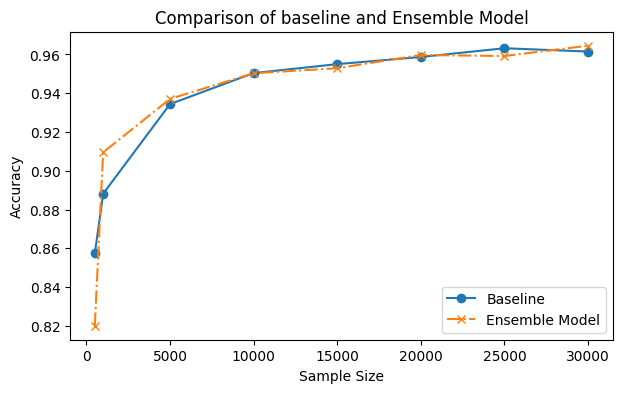

In [32]:
M = [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]
plot(M, baseline_accuracy, M, ensemble_accuracy, "Ensemble Model")

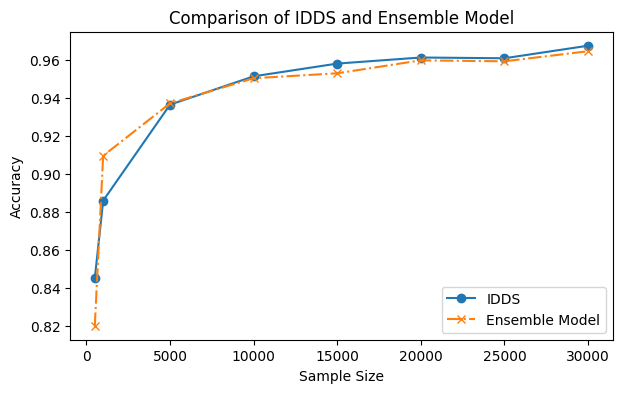

In [33]:
plt.figure(figsize=(7,4))
plt.plot(M, idds_accuracy, label = "IDDS", linestyle="-", marker="o")
plt.plot(M, ensemble_accuracy, label = "Ensemble Model", linestyle="-.", marker="x")
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.title(f"Comparison of IDDS and Ensemble Model")
plt.legend()
plt.show()

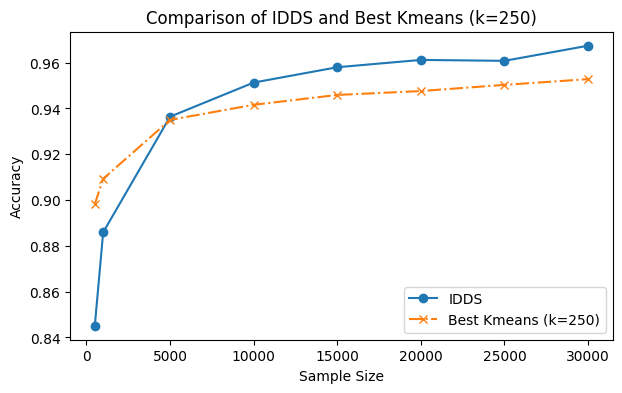

In [34]:
plt.figure(figsize=(7,4))
plt.plot(M, idds_accuracy, label = "IDDS", linestyle="-", marker="o")
plt.plot(M, kmeans_accuracy[-1], label = "Best Kmeans (k=250)", linestyle="-.", marker="x")
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.title(f"Comparison of IDDS and Best Kmeans (k=250)")
plt.legend()
plt.show()

In [38]:
def final_ensemble(x_train, y_train, x_test, y_test):
  ensemble_accuracy = []
  ensemble_precision = []

  for M in [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]:
    x_subset = []
    y_subset = []

    if M <= 5000:
      X, Y = kmeans_subset(x_train, y_train, 250, M)
      for (x, y) in zip(X, Y):
        x_subset.append(x)
        y_subset.append(y)

    else:
      X, Y = idds_subset(x_train, y_train, M)
      for (x, y) in zip(X, Y):
        x_subset.append(x)
        y_subset.append(y)

    print("Prototype size -> ", len(x_subset))

    knn = KNN(np.asarray(x_subset), np.asarray(y_subset))
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    ensemble_accuracy.append(accuracy)
    precision = precision_score(y_test, y_pred, average=None)
    ensemble_precision.append(precision)
    print(f"Ensemble accuracy for M={M} => {accuracy}")
    print(f"Ensemble precision score for M={M} => {precision}")

  return ensemble_accuracy, ensemble_precision

In [39]:
final_ensemble_accuracy, final_ensemble_precision = final_ensemble(x_train, y_train, x_test, y_test)

Prototype size ->  500
Ensemble accuracy for M=500 => 0.8982
Ensemble precision score for M=500 => [0.93469786 0.86759045 0.96166134 0.88681102 0.91810842 0.87147689
 0.94364754 0.8974359  0.93004587 0.79800725]
Prototype size ->  1000
Ensemble accuracy for M=1000 => 0.9093
Ensemble precision score for M=1000 => [0.9303001  0.88512982 0.96280553 0.90456853 0.91621912 0.88150609
 0.94335736 0.90640394 0.9295302  0.84659091]
Prototype size ->  5000
Ensemble accuracy for M=5000 => 0.935
Ensemble precision score for M=5000 => [0.94664032 0.92739274 0.95887663 0.93597561 0.95948827 0.90305011
 0.94326241 0.93346574 0.94835165 0.89661836]
Prototype size ->  11367
Ensemble accuracy for M=10000 => 0.9517
Ensemble precision score for M=10000 => [0.95837463 0.95439189 0.96987952 0.95266868 0.96380558 0.9293722
 0.95514781 0.9375     0.96634093 0.92920354]
Prototype size ->  18409
Ensemble accuracy for M=15000 => 0.9566
Ensemble precision score for M=15000 => [0.9632572  0.94869638 0.97693079 0.9

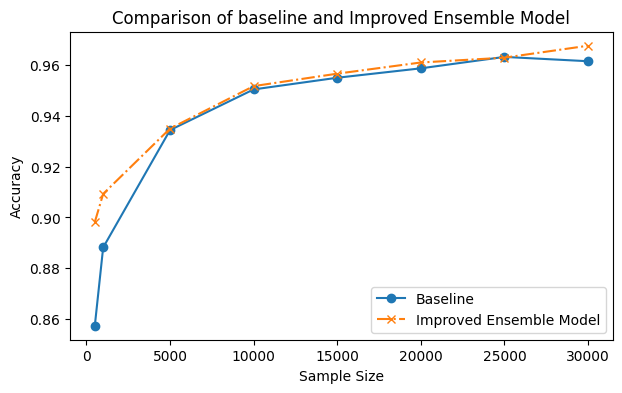

In [40]:
M = [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]
plot(M, baseline_accuracy, M, final_ensemble_accuracy, "Improved Ensemble Model")